In [22]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from cycler import cycler

import aux_funcs
import itur_p527 as p527
import itur_p2040 as p2040
import circular_lossy_waveguide as clw
import circular_metal_waveguide as cmw

In [4]:
freqs = np.logspace(8, 12, 401)
freqs /= 1e9
pipe_diameters = np.logspace(-1, 2, 301)
temps = np.logspace(5, 25, 5, dtype='int')
water_vols = np.linspace(0.1, 0.9, 5)

In [3]:
test_soil = p527.SOILS['clay_loam']
test_water_vol = 0.5
test_temp = 10.0
test_soil_permittivity_pos = np.zeros(np.size(freqs), dtype=complex)
test_soil_permittivity_neg = np.zeros(np.size(freqs), dtype=complex)
test_soil_tan_delta_pos = np.zeros(np.size(freqs), dtype=float)
test_soil_tan_delta_neg = np.zeros(np.size(freqs), dtype=float)

for idx, freq in enumerate(freqs):
    foo = p527.soil_permittivity(freq, test_temp,test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_water_vol)
    test_soil_permittivity_pos[idx] = foo
    test_soil_permittivity_neg[idx] = complex(foo.real, -foo.imag)
    test_soil_tan_delta_pos[idx] = aux_funcs.complex_permittivity_to_tan_delta(test_soil_permittivity_pos[idx].real, test_soil_permittivity_pos[idx].imag)
    test_soil_tan_delta_neg[idx] = aux_funcs.complex_permittivity_to_tan_delta(test_soil_permittivity_neg[idx].real, test_soil_permittivity_neg[idx].imag)

In [18]:
test_soil_attenuation_rate = np.zeros(np.size(freqs))
test_soil_tx_coeff_te = np.zeros(np.size(freqs))
test_soil_tx_coeff_tm = np.zeros(np.size(freqs))
test_soil_prop_const = np.zeros(np.size(freqs))

In [7]:
for idx, freq in enumerate(freqs):
    test_soil_attenuation_rate[idx] = p2040.material_attenuation_rate(freq, test_soil_permittivity_neg[idx].real, test_soil_tan_delta_neg[idx])

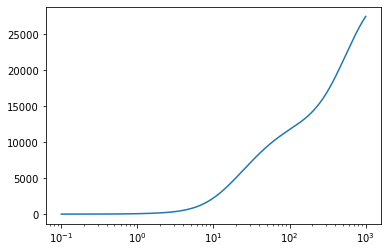

In [8]:
plt.semilogx(freqs, test_soil_attenuation_rate)

In [50]:
for idx, freq in enumerate(freqs):
    foo = aux_funcs.plane_wave_prop_const(freq, test_soil_permittivity_neg[idx].real, test_soil_permittivity_neg[idx].imag, 1.0)
    test_soil_prop_const[idx] = aux_funcs.nepers_to_db(np.abs(foo[0]))

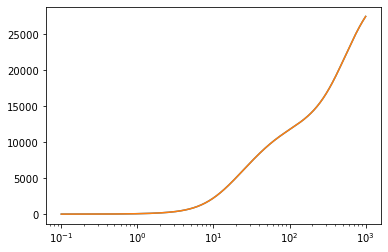

In [13]:
plt.semilogx(freqs, test_soil_prop_const)
plt.semilogx(freqs, test_soil_attenuation_rate)

In [58]:
for idx, freq in enumerate(freqs):
    foo_te = p2040.single_layer_slab_coefficients(freq, 1.0, test_soil_permittivity_neg[idx], 0.0, 'TE')
    foo_tm = p2040.single_layer_slab_coefficients(freq, 1.0, test_soil_permittivity_neg[idx], 0.0, 'TM')
    if foo_tm[1] == 0:
        test_soil_tx_coeff_tm[idx] = np.nan
    elif foo_te[1] == 0:
        test_soil_tx_coeff_te[idx] = np.nan
    else:
        test_soil_tx_coeff_te[idx] = 20*np.log10(np.abs(foo_te[1]))
        test_soil_tx_coeff_tm[idx] = 20*np.log10(np.abs(foo_tm[1]))

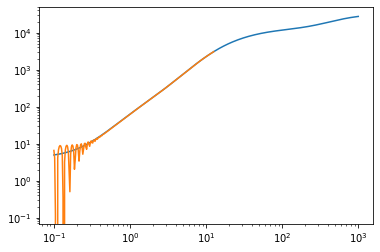

In [54]:
plt.loglog(freqs, test_soil_prop_const)
plt.loglog(freqs, -test_soil_tx_coeff_te)


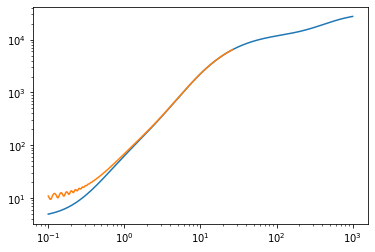

In [60]:
plt.loglog(freqs, test_soil_prop_const)
plt.loglog(freqs, -test_soil_tx_coeff_te)

In [42]:
test_soil_tx_coeff_te[120]

2.581566929659102e-07

In [72]:
soil_losses_p2040 = np.zeros((len(p527.SOILS), np.size(freqs)))
soil_losses_paper = np.zeros((len(p527.SOILS), np.size(freqs)))
soil_losses_slabs = np.zeros((len(p527.SOILS), np.size(freqs)))
soil_permittivity = np.zeros(np.size(freqs))
test_temp = 15
test_water_vol = 0.5

In [69]:
for i, soil in enumerate(p527.SOILS):
    test_soil = p527.SOILS[soil]
    for j, freq in enumerate(freqs):
        soil_permittivity = p527.soil_permittivity(freq, test_temp, test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_water_vol)
        soil_loss_tangent = aux_funcs.complex_permittivity_to_tan_delta(soil_permittivity.real, soil_permittivity.imag)
        soil_losses_p2040[i, j] = p2040.material_attenuation_rate(freq, soil_permittivity.real, soil_loss_tangent)
        foo, _ = aux_funcs.plane_wave_prop_const(freq, soil_permittivity.real, soil_permittivity.imag, 1.0)
        soil_losses_paper[i, j] = aux_funcs.nepers_to_db(foo)

In [73]:
for i, soil in enumerate(p527.SOILS):
    test_soil = p527.SOILS[soil]
    for j, freq in enumerate(freqs):
        soil_permittivity = p527.soil_permittivity(freq, test_temp, test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_water_vol)
        soil_perm_neg = complex(soil_permittivity.real, -soil_permittivity.imag)
        foo = p2040.single_layer_slab_coefficients(freq, 1.0, soil_perm_neg, 0, 'TE')
        if foo[1] == 0.0:
            soil_losses_slabs[i, j] = np.nan
        else:
            soil_losses_slabs[i, j] = 20 * np.log10(np.abs(foo[1]))

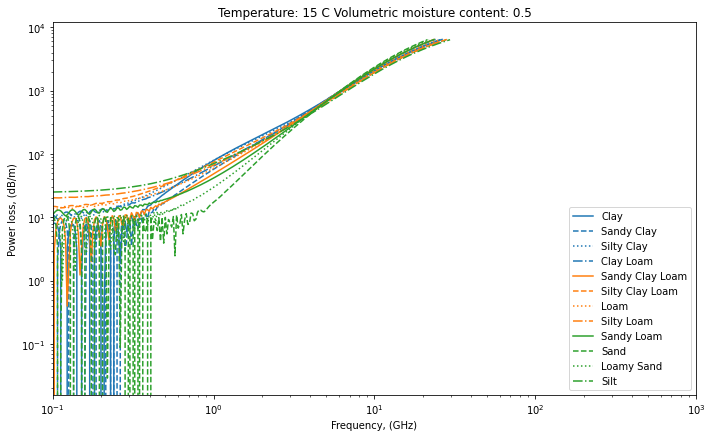

In [75]:
custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]) * cycler(linestyle=['-', '--', ':', '-.']))
fig, ax = plt.subplots()
ax.set_prop_cycle(custom_cycler)
color_idx = np.linspace(0, 1, len(p527.SOILS))
fig.set_size_inches(10, 10/1.618)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(np.min(freqs), np.max(freqs))
#ax.set_ylim(1, 14)
#ax.set_yticks([1, 2, 4, 6, 8, 10, 12, 14])
#ax.set_yticklabels([1, 2, 4, 6, 8, 10, 12, 14])
for i, soil in enumerate(p527.SOILS):
#    print(soil)
    ax.plot(freqs, -soil_losses_slabs[i, :], label=soil.replace('_', ' ').title())
ax.set_xlabel('Frequency, (GHz)')
ax.set_ylabel('Power loss, (dB/m)')
ax.set_title(f'Temperature: {test_temp} C Volumetric moisture content: {test_water_vol}')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f'Line Plot Fixed Temperature - {test_temp} Fixed mv - {test_water_vol}.png', dpi=600, bbox_inches='tight')

In [10]:
test_soil = p527.SOILS['clay_loam']
test_soil_temp = 10.0
test_soil_water_vol = 0.5
test_soil_er = np.zeros(np.size(freqs), dtype=complex)
test_soil_tan_delta = np.zeros(np.size(freqs))

for idx, freq in enumerate(freqs):
    foo = p527.soil_permittivity(freq, test_soil_temp, test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_soil_water_vol)
    test_soil_er[idx] = complex(foo.real, -foo.imag)
    test_soil_tan_delta[idx] = aux_funcs.complex_permittivity_to_tan_delta(foo.real, foo.imag)

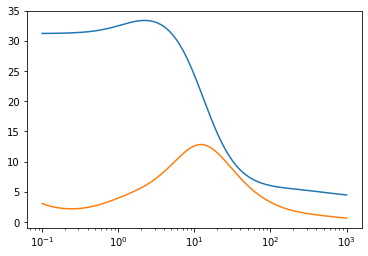

In [13]:
plt.semilogx(freqs, np.real(test_soil_er))
plt.semilogx(freqs, -np.imag(test_soil_er))

In [18]:
loss_p2040 = np.zeros((np.size(freqs), np.size(pipe_diameters)))
loss_clw = np.zeros((np.size(freqs), np.size(pipe_diameters)))
loss_cmw = np.zeros((np.size(freqs), np.size(pipe_diameters)))

In [41]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        loss_p2040[i, j] = p2040.dielectric_wvg_loss(freq, diameter, diameter, test_soil_er[i].real, np.abs(test_soil_er[i].imag), 'vertical', 'circle')

In [42]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        foo = clw.calc_attenuation_constant(freq, diameter, test_soil_er[i], 'HE', 1, 1)
        loss_clw[i, j] = aux_funcs.nepers_to_db(foo) 

In [16]:
xv, yv = np.meshgrid(freqs, pipe_diameters, indexing='ij')

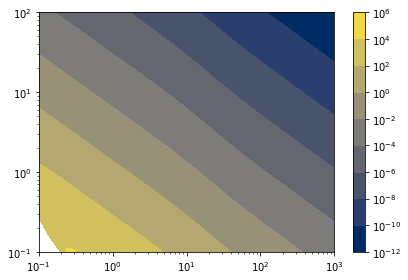

In [50]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')
contour = ax.contourf(xv, yv, loss_p2040, cmap='cividis', norm=colors.LogNorm())

fig.tight_layout()

cbar = fig.colorbar(contour)
fig.savefig('1.png', dpi=600)

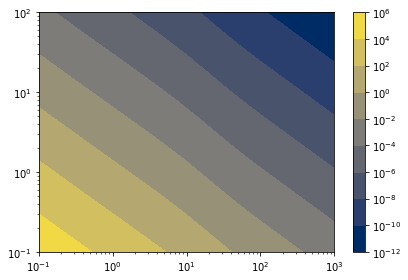

In [45]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')
contour = ax.contourf(xv, yv, loss_clw, cmap='cividis', norm=colors.LogNorm())

fig.tight_layout()

cbar = fig.colorbar(contour)
fig.savefig('2.png', dpi=600)

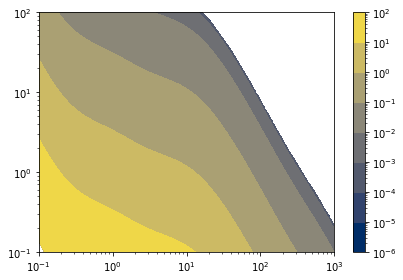

In [48]:
baz = ((np.abs(loss_clw) - np.abs(loss_p2040)) / np.abs(loss_clw)) * 100
baz_ma = np.ma.masked_where(baz == 0, baz)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
contour = ax.contourf(xv, yv, baz, cmap='cividis', norm=colors.LogNorm())

fig.tight_layout()

cbar = fig.colorbar(contour)

fig.savefig('3.png', dpi=600)

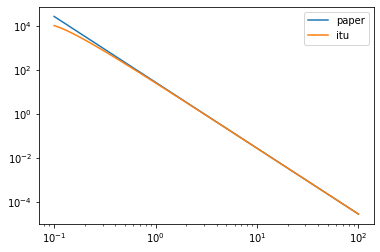

In [64]:
plt.loglog(pipe_diameters, loss_clw[50, :], label='paper')
plt.loglog(pipe_diameters, loss_p2040[50, :], label='itu')
plt.legend()

In [60]:
freqs[100]

1.0

In [65]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        foo = cmw.calc_attenuation_constant(freq, diameter, 'TE', 1, 1, 5.88e7, 1)
        loss_cmw[i, j] = aux_funcs.nepers_to_db(foo)

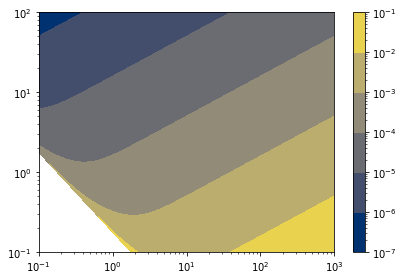

In [66]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')
contour = ax.contourf(xv, yv, loss_cmw, cmap='cividis', norm=colors.LogNorm())

fig.tight_layout()

cbar = fig.colorbar(contour)